# Purpose of Notebook

The purpose of this notebook is to offer an example answer to the guided project for the Sequential Models for Deep Learning course. Since the choice of model predictors is up to the student, results can differ. Use this solution as a guide for how to structure your own answer.

# Time-Series Forecasting on the S&P 500

**Context**: We are working as traders on the S&P 500 futures desk. We have been tasked with building a model to better forecast how this index will move based on its behavior over the past several years. The better our forecast performs, the more effectively and lucratively our desk will be able to trade these futures.

## Introduction

The dataset we will be working with is from [Yahoo Finance via Kaggle](https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price), and it contains S&P 500 Index prices from 2015 through 2020.

Before we get into the data, let's set some random seed values to improve the reproducibility of the models we will build later on.

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import random

# Seed code
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

## Data Wrangling and Exploration

First, we will load in the data and inspect it to determine what steps will be required for cleaning and preprocessing.

In [2]:
# Import
import pandas as pd

# Load and inspect the data
stock_data = pd.read_csv("yahoo_stock.csv")
stock_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


We can see that the data contains seven columns: `Date`, `High`, `Low`, `Open`, `Close`, `Volume`, and `Adj Close`.

We will want to set the index of the DataFrame to the `Date` column to prepare for time series forecasting, and decide what other column(s) to use for the forecast itself. For now, we are going to use only the `Adj Close` column, which is the closing price of the S&P 500 index, [adjusted for dividends](https://www.investopedia.com/articles/investing/091015/how-dividends-affect-stock-prices.asp). Based on this decision, we modify the DataFrame to drop the other columns.

We should also ensure that the data is sorted by its `Date` column.

In [3]:
# Select relevant columns, sort data, and set index
stock_data = stock_data[["Date", "Adj Close"]]
stock_data = stock_data.sort_values("Date")
stock_data = stock_data.set_index("Date")

# Inspect the data
stock_data.head()

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


We should also double-check that we don't have any missing or erroneous values in our dataset, and consider forward-filling or interpolating if necessary.

In [4]:
# Check for missing or erroneous values
print("Info: ")
stock_data.info()
print("\nDescribe: \n", stock_data.describe())
print("\nSkew: \n", stock_data.skew())

Info: 
<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 2015-11-23 to 2020-11-20
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1825 non-null   float64
dtypes: float64(1)
memory usage: 28.5+ KB

Describe: 
          Adj Close
count  1825.000000
mean   2647.856284
std     407.301177
min    1829.079956
25%    2328.949951
50%    2683.340088
75%    2917.520020
max    3626.909912

Skew: 
 Adj Close    0.081869
dtype: float64


Great! No missing values, and everything seems to be within a reasonable range. The low skew value for `Adj Close` indicates we don't have any outliers to be concerned about.

Before we begin preparing the data for modeling by scaling the variable to be forecasted (`Adj Close`) and splitting the dataset for training, validation, and testing, let's quickly visualize the data.

Text(0, 0.5, 'Adjusted Close')

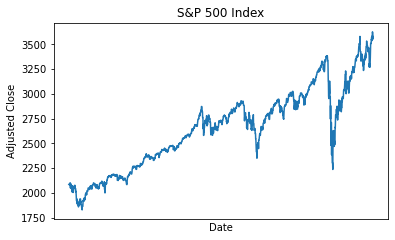

In [5]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the data
plt.plot(stock_data)

# Add title and axis labels
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')

The plot is looking great! We can see that we have data from about five years to work with. There are no gaps, and there are some visible dips and spikes.

Clearly there is a pattern here (it's not just random noise), and we want to build a model that can predict that pattern. Before we can do that, we need to preprocess the data so we can build and train an RNN model. Let's move on to that data preprocessing.

## Data Preprocessing

Before we can build and train an RNN model to make forecasts based on this data, we need to complete two preprocessing steps:
- Split the data into `train`, `validation`, and `test` sets, using 50% of the data for training and 25% each for validation and testing.
- Scale the data to between `0` and `1`, fitting the scaler to the training data and using the fitted scaler to scale all three datasets.

In [6]:
# Import
from sklearn.preprocessing import MinMaxScaler

# Split into train, validation, and test sets
train_size = int(len(stock_data) * 0.5)
validation_size = int(len(stock_data) * 0.25)
train_df = stock_data.iloc[0:train_size, :]
validation_df = stock_data.iloc[train_size:train_size + validation_size, :]
test_df = stock_data.iloc[train_size + validation_size:len(stock_data), :]

# Fit scaler
scaler = MinMaxScaler()
scaler.fit(train_df)

# Scale data
train = pd.DataFrame(scaler.transform(train_df), columns=['Adj Close'], index=train_df.index)
validation = pd.DataFrame(scaler.transform(validation_df), columns=['Adj Close'], index=validation_df.index)
test = pd.DataFrame(scaler.transform(test_df), columns=['Adj Close'], index=test_df.index)

We will also want to shape our data into fixed-length time windows and reshape it into NumPy arrays to prepare it for TensorFlow models. We will do this in a way that is repeatable and does not overwrite our `train`, `validation`, and `test` variables so that we have the freedom to modify this window size later.

In [7]:
# Define a helper function to construct windowed datasets
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        window = dataset.iloc[i:(i + window_size), 0]
        target = dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Set the desired window size
window_size = 10

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Build and Train a Basic RNN Model

Now comes the fun part! We've thoroughly prepared our data for modeling and now we need to build a TensorFlow model to make forecasts. Let's start with a `SimpleRNN` model.

In [8]:
# Imports
from tensorflow import keras
from tensorflow.keras import layers

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                210       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


Great! And now that we've built the model, let's train it on our training dataset and evaluate its performance using the validation dataset. Note that we are _not_ using the `test` dataset yet because we want to have a clean, untouched testing dataset for our final model evaluation. We may have skipped this step in previous lessons for simplicity, but it is a best practice to set aside an untouched testing set during the model optimization process.

In [9]:
# Import
from sklearn.metrics import r2_score

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

14/14 [==============================] - 1s 3ms/step
-2.7877363666898582


Yikes! That R-Squared score is not looking very good. Let's see if we can improve upon this model.

## Build and Train an LSTM Model

Let's repeat the above steps for an LSTM model and see if we can improve performance.

In [10]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(10, input_shape=(1, window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
14/14 [==============================] - 1s 3ms/step
-44.39475292905578


That didn't improve things like we hoped. For now, let's keep the LSTM in place until we're ready to fully optimize the model, and we can decide then whether it's worth keeping. For now, let's move onto the next section to see what other techniques we can try to improve this model.

## Add a Convolutional Layer

Next, we are going to branch out a bit from the basic RNN or LSTM model and try adding a convolutional layer to see if this improves the model performance.

In [11]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(64, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(10, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10)                3000      
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,825
Trainable params: 3,825
Non-trainable params: 0
____________________________________________________

These are still pretty terrible results. Let's go further and try modifying other model parameters to fully optimize this model, at which point we may or may not keep the convolutional layer.

## Optimize the Model

Now we can go further to optimize this model by adding layers, changing the number of nodes in each layer, increasing the number of training epochs, and modifying the window size.

In [12]:
# Set the desired window size
window_size = 25

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=35)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 128)            3328      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                      

Overall, this is starting to look really good! We are achieving an R-Squared value between `0.90` and `0.95` on the validation set, which is impressive. As a final performance check, we should now compute and visualize the performance on the testing set.

## Evaluate Model Performance

Finally! We've settled on a model that we can be satisfied with, so let's use this model to make predictions on the testing set and compute our final R-Squared. While we're at it, since we'll need them for plotting, let's make predictions on all three sets: training, validation, and testing.

In [19]:
# Make predictions on all three sets
train_pred = model.predict(X_train)
validation_pred = model.predict(X_validation)
test_pred = model.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_validation, validation_pred), "  --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

14/14 [==============================] - 0s 3ms/step
0.9947958915297632  --> Training Set
0.941325545898109   --> Validation Set
0.9421163908433968  --> Test Set


Excellent! The R-Squared value from validation seems to have held up in testing, which is a great sign. Now it's time to visualize this performance. First, we'll need to undo the scaling and windowing preprocessing we've done.

In [14]:
# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
validation_pred = scaler.inverse_transform(validation_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(stock_data), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(stock_data), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[len(train_pred) + (window_size * 2) + 1:len(train_pred) + len(validation_pred) + (window_size * 2) + 1, :] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(stock_data), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(validation_pred) + (window_size * 3) + 2:len(stock_data) - 1, :] = test_pred

Finally, let's plot the un-scaled and un-windowed data on top of the original `stock_data` dataset.

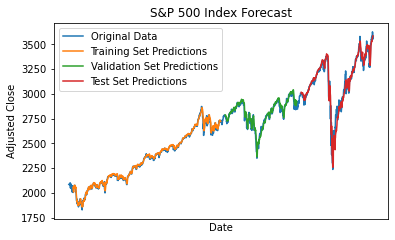

In [15]:
# Plot the original data
plt.plot(stock_data, label="Original Data")

# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_validation_pred, label="Validation Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

The visualization looks as great as the R-Squared suggested it might. The real test, of course, would be to make some predictions for the future and do some trades (or pretend to do some trades — "paper trading" as we call it), then see if we can make any money. Investment advice is way outside the scope of this course, and the stock market has a way of being a "harsh teacher," so please be cautious and remember that this project was only meant to be fun and educational! If successfully predicting the market trends was "this easy," everyone would do it.